In [1]:
from customcheckpoint import CustomModelCheckpoint
from keras.callbacks import EarlyStopping

/home/parmeet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/parmeet/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1243327373223696088, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5352456192
 locality {
   bus_id: 1
 }
 incarnation: 17058806628359537036
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [11]:
def convert_bboxes(bboxes):
    features = []
    for b in bboxes:
        height = math.sqrt((b[0]-b[2])**2 + (b[1]-b[3])**2)
        width = math.sqrt((b[2]-b[4])**2 + (b[3]-b[5])**2)
        
        cx = (b[0] + b[4])/2.0
        cy = (b[1] + b[5])/2.0
        
        angle = math.atan2((b[0]-b[2]),(b[1]-b[3]))
        features.append([height,width,cx,cy,angle])
    return np.array(features)

In [5]:
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [6]:

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)


x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)

model = Model(inputs=cnn_base.input, outputs=x)
model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy',iou_metric])
initial_weights = model.get_weights()

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

for i in range(5):
    eps = 50
    if i==0:
        eps=20
    print("Loading file")
    #model.save_weights('model.h5')
    with open('data-ruler_detection'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,_,test_images,test_bboxes,_ = pickle.load(file)
    try:
        with open('ruler_detection'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
            model.set_weights(model_weights)
    except:
        print("setting initial weights")
        model_weights = initial_weights
        model.set_weights(model_weights)    
        print("loaded")
    checkpoint = CustomModelCheckpoint('ruler_detection'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    callbacks_list = [checkpoint,EarlyStopping(patience=30)]
#     history = model.fit(x=np.array(train_images),y=np.array(train_bboxes),batch_size=5,epochs=eps,
#                        validation_data=(np.array(test_images),np.array(test_bboxes)),callbacks=callbacks_list)
#     history_record.append(history)
    
    try:
        with open('ruler_detection'+str(i)+'.hd5','rb') as f:
            print("loading best")
            model_weights = pickle.load(f)
            print("loaded best weights")
            model.set_weights(model_weights)
    except:
        print("problem setting best weights")
        model_weights = initial_weights
        model.set_weights(model_weights)    
        print("loaded")
    train_score = model.evaluate(x=np.array(train_images),y=np.array(train_bboxes),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_bboxes), batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(train_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)

Loading file
loaded model
loading best
loaded best weights
66/66 [==============================] - 2s 28ms/step
predicting
Test Score [30.48856041648171, 0.8787878751754761, 0.7378530050768997]
Loading file
loaded model
loading best
loaded best weights
66/66 [==============================] - 1s 10ms/step
predicting
Test Score [40.490906686493844, 0.8787878896250869, 0.7378710996020924]
Loading file
loaded model
loading best
loaded best weights
66/66 [==============================] - 1s 10ms/step
predicting
Test Score [27.64893508679939, 0.8636363437681487, 0.7590014121749185]
Loading file
loaded model
loading best
loaded best weights
66/66 [==============================] - 1s 10ms/step
predicting
Test Score [22.62984709306197, 0.9242424368858337, 0.7537838798580747]
Loading file
loaded model
loading best
loaded best weights
66/66 [==============================] - 1s 10ms/step
predicting
Test Score [20.214104854699336, 0.9242424224362229, 0.748094815196413]


In [10]:
with open('ruler_detection_prediction.pckl','wb') as file:
    pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [17]:
for i in range(5):
    with open('ruler-detection-rotated'+str(i)+'.pckl','rb') as file:
            train_images,train_bboxes,_,test_images,test_bboxes,_ = pickle.load(file)
    testing_bboxes = convert_bboxes(test_bboxes)
    height_error = 0
    width_error = 0
    for j,h in zip(testing_bboxes,test_pred[i]):
        height = max(j[0],j[1])
        width = min(j[0],j[1])

        height_dash = max(abs(h[0]-h[2]),abs(h[1]-h[3]))
        width_dash = min(abs(h[0]-h[2]),abs(h[1]-h[3]))
        #print(width,width_dash)
        #print(height_dash,width_dash)
        height_error =  height_error + abs(height_dash-height)
        width_error =  width_error + abs(width_dash-width)     
    print(height_error/len(testing_bboxes),width_error/len(testing_bboxes))

11.679726389980184 14.95909529685649
7.2191477083350835 12.745920032209172
14.073772073320693 13.707265858501518
12.382753857649258 11.513516777265364
12.05461485083728 8.70801650976173


In [ ]:
with open('ruler_detection_prediction.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

NameError: name 'history' is not defined

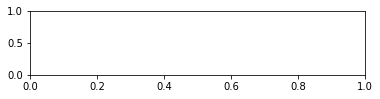

In [8]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [18]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101

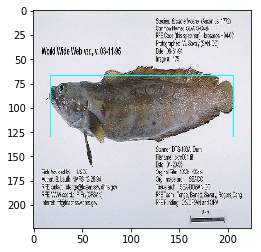

In [36]:
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

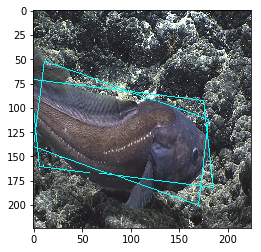

In [28]:
idx = 5
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

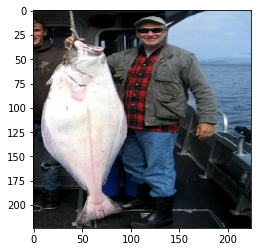

In [78]:
idx = 22
img = test_images[idx]
[[w,h,cx,cy,angle]] = mod.predict(np.expand_dims(test_images[idx],axis=0))[0]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [57]:
w,h,cx,cy,angle

(0.9990823, 0.00075547496, 4.3644923e-05, 0.00010419192, 1.4448374e-05)

In [53]:
mod.predict(np.expand_dims(test_images[6],axis=0))

[array([[149.92322 ,  82.941605, 126.17159 , 112.74586 ,  -0.889715]],
       dtype=float32),
 array([[1.1669288e-03, 9.3571018e-08, 7.4474216e-02, 3.6341050e-01,
         5.6094831e-01]], dtype=float32)]

In [79]:
test_scores

[]